# **Finetuning Bert for Sentiment Analysis**

### **Using tensorflow & GPU**

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.0
tensorflow_hub version :  0.7.0


In [ ]:
import numpy as np

### Training Data

https://drive.google.com/open?id=15wh7uahh6RNQcFI_9w3M3LZt5dn1PQQI

In [ ]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '15wh7uahh6RNQcFI_9w3M3LZt5dn1PQQI'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('all_training_data.csv')
data0 = pd.read_csv('all_training_data.csv')
print(data0)

      Unnamed: 0                  0  1
0              0           千呼万唤始出来，  0
1              1   尼康的APSC小相机终于发布了，  0
2              2  COOLPIX A. 你怎么看呢？  0
3              3     我看，尼康是挤牙膏挤惯了啊，  0
4              4       1，外观既没有V1时尚，  1
...          ...                ... ..
5773        5773            下面附点样片，  0
5774        5774              随便拍的，  0
5775        5775   大部分都是JPG、鲜艳模式直出，  0
5776        5776            技术确实不精，  0
5777        5777             望大家海涵。  0

[5778 rows x 3 columns]


In [ ]:
data = data0
data.head()

,Unnamed: 0,0,1
0,0,千呼万唤始出来，,0
1,1,尼康的APSC小相机终于发布了，,0
2,2,COOLPIX A. 你怎么看呢？,0
3,3,我看，尼康是挤牙膏挤惯了啊，,0
4,4,1，外观既没有V1时尚，,1


In [ ]:
sentences = data['0']
labels = data['1']

In [ ]:
len(data)

5778

### Test Data
https://drive.google.com/file/d/1Z407wytknTvwQhbiyfzL6ZkXL5o5DmeO/view?usp=sharing

In [ ]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1Z407wytknTvwQhbiyfzL6ZkXL5o5DmeO'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('testHAHA.csv')
dataTe = pd.read_csv('testHAHA.csv')
print(dataTe)

      Unnamed: 0                                        0   2
0              0  一直潜水，昨天入d300s +35 1.8g，谈谈感受，dx说，标题一定要长！   0
1              1                              在我们这尼康一个代理商   0
2              2                             开的大型体验中心提的货，   0
3              3                             老板和销售mm都很热情，   0
4              4                                     不欺诈，   0
...          ...                                      ...  ..
1390        1390                                 并且位置非常好，  49
1391        1391                         这可能是地球上最难奈的相机机身。  49
1392        1392             如果您想要一台可以拍出几乎所有东西而又不是奥林巴斯的相机  49
1393        1393                 （即使在三脚架上也能给您带来很多很多机会错失），  49
1394        1394                              那么这台相机很适合您。  49

[1395 rows x 3 columns]


### **Import BERT for word embedding (using bert-base-chinese)**

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

Loading BERT tokenizer...


### **word embedding**

In [ ]:
input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    input_ids.append(encoded_sent)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  千呼万唤始出来，
Token IDs: [101, 1283, 1461, 674, 1542, 1993, 1139, 3341, 8024, 102]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  82


In [ ]:
from keras.preprocessing.sequence import pad_sequences

# maximum sequence length
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# attention masks
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [ ]:
# split data
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=8467, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=8467, test_size=0.1)

In [ ]:
# Convert inputs and labels into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.from_numpy(np.array(train_labels))
validation_labels = torch.from_numpy(np.array(validation_labels))

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# DataLoader for training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### **Setting up Model：bert-base-chinese，num_labels set to3**


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-chinese",
    num_labels = 3, # 3 categories
    output_attentions = False,
    output_hidden_states = False,
)

# run on GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# the model's parameters.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (21128, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### **Setting up Optimizer：lr = 2e-5**

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np
# accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    #returns hh:mm:ss
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))


### **Train Model**

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    ###Training###
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # forward pass
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = outputs[0]

        # training loss
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    ### Validation ###

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch


        with torch.no_grad():

            # Forward pass, logit predictions.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1


    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:10.
  Batch    80  of    325.    Elapsed: 0:00:19.
  Batch   120  of    325.    Elapsed: 0:00:29.
  Batch   160  of    325.    Elapsed: 0:00:38.
  Batch   200  of    325.    Elapsed: 0:00:48.
  Batch   240  of    325.    Elapsed: 0:00:57.
  Batch   280  of    325.    Elapsed: 0:01:07.
  Batch   320  of    325.    Elapsed: 0:01:16.

  Average training loss: 0.45
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.87
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:10.
  Batch    80  of    325.    Elapsed: 0:00:19.
  Batch   120  of    325.    Elapsed: 0:00:29.
  Batch   160  of    325.    Elapsed: 0:00:38.
  Batch   200  of    325.    Elapsed: 0:00:48.
  Batch   240  of    325.    Elapsed: 0:00:57.
  Batch   280  of    325.    Elapsed: 0:01:07.
  Batch   320  of    325.    Elapsed: 0:01:16.

  Average training loss: 0.28
  

### **Loss Plot**

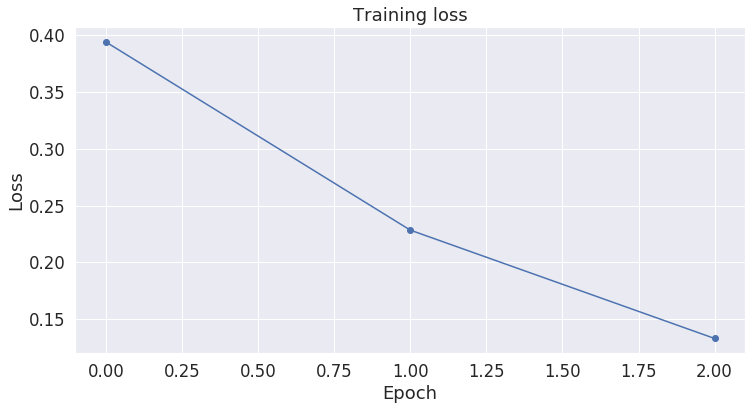

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### **Test Dataset**

In [ ]:
dataTe.head()

,Unnamed: 0,0,2
0,0,一直潜水，昨天入d300s +35 1.8g，谈谈感受，dx说，标题一定要长！,0
1,1,在我们这尼康一个代理商,0
2,2,开的大型体验中心提的货，,0
3,3,老板和销售mm都很热情，,0
4,4,不欺诈，,0


In [ ]:
len(dataTe)

1395

In [ ]:
import pandas as pd
sentences = dataTe['0']

In [ ]:
sentences[0]

'一直潜水，昨天入d300s +35 1.8g，谈谈感受，dx说，标题一定要长！'

In [ ]:
# Tokenize sentences
input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### **Prediction**

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch

  with torch.no_grad():
      # Forward pass, logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

Predicting labels for 1,395 test sentences...
    DONE.


### **Evaluation**

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.631


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
accuracy = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions, average='macro')
recall = recall_score(flat_true_labels, flat_predictions, average='macro')
fscore = f1_score(flat_true_labels, flat_predictions, average='macro')

print("Accuracy: %g\tPrecision: %g\tRecall: %g\tF-score: %g" % (
    accuracy, precision, recall, fscore))

Accuracy: 0.882353	Precision: 0.722687	Recall: 0.732148	F-score: 0.727334


### **Results on the Test Dataset**

In [ ]:
flat_predictions[0:99]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0])

In [ ]:
np.array(flat_true_labels[0:99])

array([2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0])

In [ ]:
dataNew = dataTe

In [ ]:
dataNew['pred'] = flat_predictions

In [ ]:
dataNew.head()

,Unnamed: 0,0,2,pred
0,0,一直潜水，昨天入d300s +35 1.8g，谈谈感受，dx说，标题一定要长！,0,0
1,1,在我们这尼康一个代理商,0,0
2,2,开的大型体验中心提的货，,0,0
3,3,老板和销售mm都很热情，,0,0
4,4,不欺诈，,0,0


### **Format Conversion**

In [ ]:
New_pred = []
for i in flat_predictions:
    if i == 0:
        New_pred.append("neutral")
    elif i == 1:
        New_pred.append("negative")
    else:
        New_pred.append("positive")

In [ ]:
dataNew.tail(26)

,Unnamed: 0,0,2,pred,New_pred
1369,1369,虽然论坛最近吵得很厉害，,48,0,neutral
1370,1370,但不可否认宾得是个相对低调的厂商。,48,0,neutral
1371,1371,我真的很喜欢这款相机的感觉和操作，,49,2,positive
1372,1372,但是软件和图像质量却完全不同。,49,0,neutral
1373,1373,我的第一个K-1持续了几个月才停止保存图像-如果我拍摄了五十张照片，,49,0,neutral
1374,1374,它可能会保存前三个图像。,49,0,neutral
1375,1375,在对相机和存储卡进行了广泛的测试和重新格式化以及使用不同的存储卡后，,49,0,neutral
1376,1376,问题仍然存在，,49,0,neutral
1377,1377,然后我将K-1换成了功能齐全的替代品。,49,0,neutral
1378,1378,有时会出现其他软件“故障”，,49,0,neutral


In [ ]:
dataNew['New_pred'] = New_pred

In [ ]:
sent = list(dataNew['2'] )
sent[1:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
tmpQ = -1
whole = []
tmpC = 0
tmp = ""
for every in sent:
    if every == tmpQ:
        tmp += New_pred[tmpC]
        tmp += "    "
        tmpC += 1
    else:
        tmpQ = every
        whole.append(tmp)
        tmp = ""
        tmp += New_pred[tmpC]
        tmp += "    "
        tmpC += 1

In [ ]:
whole[0:10]

['',
 'neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    negative    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    positive    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    positive    negative    positive    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    negative    neutral    neutral    neutral    neutral    positive    neutral    neutral    neutral    neutral    neutral    neutral    neutral    negative    neutral    negative    neutral    negative    negative    neutral    neutral    neutral    neu

In [ ]:
new_whole = whole[1:]
new_whole[:10]

['neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    negative    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    positive    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    positive    negative    positive    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    neutral    negative    neutral    neutral    neutral    neutral    negative    neutral    neutral    neutral    neutral    n

In [ ]:
tmpQ = -1
whole = []
tmpC = 0
tmp = []
for every in sent:
    if every == tmpQ:
        tmp.append(New_pred[tmpC])
        tmpC += 1
    else:
        tmpQ = every
        whole.append(tmp)
        tmp = []
        tmp.append(New_pred[tmpC])
        tmpC += 1

In [ ]:
new_whole = whole[1:]
new_whole[:1]

[['neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'negative',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'positive',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'positive',
  'negative',
  'positive',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neutral',
  'neut

### **Export Data（Final Results）**

In [ ]:
import csv
with open('output22.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(len(new_whole)):
      tsv_output.writerow(new_whole[i])

In [ ]:
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
from google.colab import files
files.download('output22.tsv')